In [2]:
!pip install cmake gym scipy

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.


In [3]:
import pandas as pd
import seaborn as sns

In [4]:
import gym
env = gym.make("Taxi-v3").env
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [5]:
# env.reset: Resets the environment and returns a random initial state.
# env.step(action): Step the environment by one timestep. Returns

In [6]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


--------------------------------
Let’s assume Smartcab is the only vehicle in this parking lot. We can break up the parking lot into a 5x5 grid, which gives us 25 possible taxi locations. These 25 locations are one part of our state space. Notice the current location state of our taxi is coordinate (3, 1).

You’ll also notice there are four locations that we can pick up and drop off a passenger: R, G, Y, B or [(0,0), (0,4), (4,0), (4,3)] in (row, col) coordinates. Our illustrated passenger is in location Y and they wish to go to location R.

When we also account for one additional passenger state of being inside the taxi, we can take all combinations of passenger locations and destination locations to come to a total number of states for our taxi environment; there’s four destinations and five passenger locations.

So, our taxi environment has 5×5×5×4=500 total possible states.

------------------------------------

The filled square represents the taxi, which is yellow without a passenger and green with a passenger.
The pipe ("|") represents a wall which the taxi cannot cross.
R, G, Y, B are the possible pickup and destination locations. The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.

    0 = south
    1 = north
    2 = east
    3 = west
    4 = pickup
    5 = dropoff

In [23]:
state = env.encode(3, 1, 3, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()


State: 332
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


In [8]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

In [9]:
env.s = 332  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation
rewards = []

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )
    rewards.append(reward)

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))


Timesteps taken: 839
Penalties incurred: 282


In [10]:
penalties

282

In [11]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print("Timestep: {}".format(i + 1))
        print("State: {}".format(frame['state']))
        print("Action: {}".format(frame['action']))
        print("Reward: {}".format(frame['reward']))
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Timestep: 26
State: 352
Action: 4
Reward: -10


KeyboardInterrupt: 

Not good. Our agent takes thousands of timesteps and makes lots of wrong drop offs to deliver just one passenger to the right destination.

This is because we aren't learning from past experience. We can run this over and over, and it will never optimize

### Intro to Q-learning

Q(state,action)←(1−α)Q(state,action)+α(reward+γmaxaQ(next state,all actions))

- α (alpha) is the learning rate (0<α≤1) - Just like in supervised learning settings, α is the extent to which our Q-values are being updated in every iteration.

- γ (gamma) is the discount factor (0≤γ≤1) - determines how much importance we want to give to future rewards. A high value for the discount factor (close to 1) captures the long-term effective award, whereas, a discount factor of 0 makes our agent consider only immediate reward, hence making it greedy.

In [12]:
#First, we'll initialize the Q-table to a 500×6 matrix of zeros:

import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])
q_table


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [13]:
q_table.shape

(500, 6)

In [14]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.9
epsilon = 0.2

# For plotting metrics
all_epochs = []
all_penalties = []
all_rewards = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, cum_reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        
        epochs += 1
        cum_reward += reward
        
    all_epochs.append(epochs)
    all_penalties.append(penalties)
    all_rewards.append(cum_reward)
    
    if i % 100 == 0:
        clear_output(wait=True)
        print("Episode: {}".format(i))


print("Training finished.\n")


Episode: 100000
Training finished.

Wall time: 43.5 s


In [15]:
data_tuples = list(zip(list(range(1, 100001)), all_epochs, all_penalties, all_rewards))

In [16]:
learning_df = pd.DataFrame(data_tuples, columns=['episode','epochs_to_complete','penalties', 'rewards'])

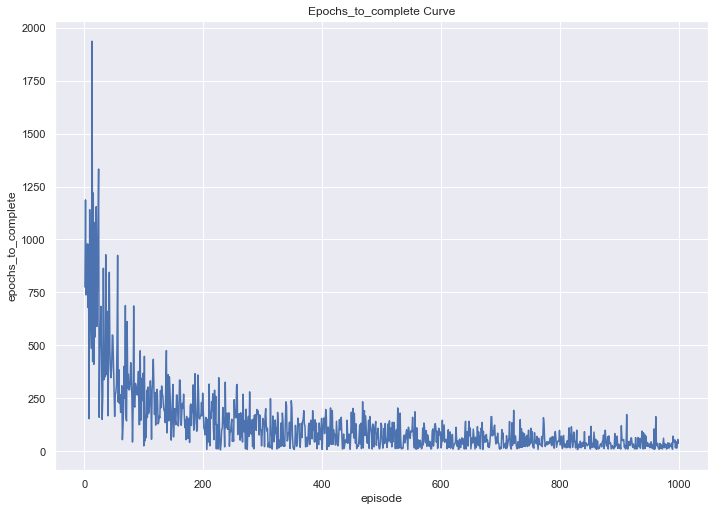

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns_plot = sns.lineplot(x='episode', y='epochs_to_complete',data = learning_df[learning_df.episode<1000]).set(title='Epochs_to_complete Curve')

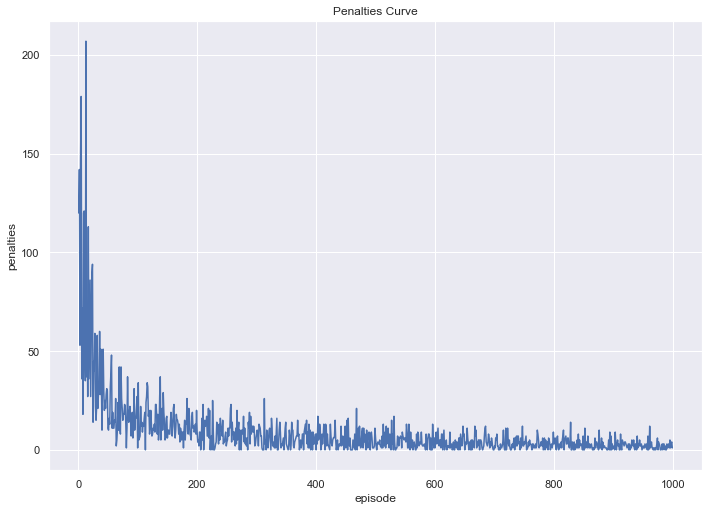

In [19]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns_plot = sns.lineplot(x='episode', y='penalties',data = learning_df[learning_df.episode<1000]).set(title='Penalties Curve')

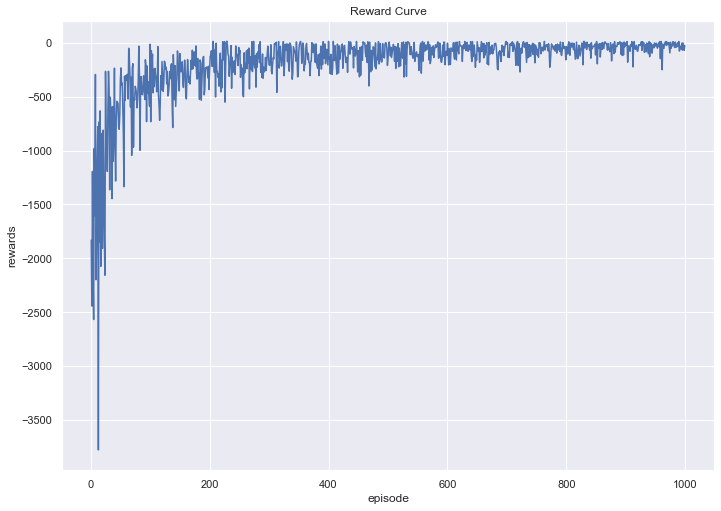

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns_plot = sns.lineplot(x='episode', y='rewards',data = learning_df[learning_df.episode<1000]).set(title='Reward Curve')

In [21]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for i in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print("Results after {} episodes:".format(episodes))
print("Average timesteps per episode: {}".format(total_epochs / episodes))
print("Average penalties per episode: {}".format(total_penalties / episodes))


Results after 100 episodes:
Average timesteps per episode: 13.27
Average penalties per episode: 0.0


In [22]:
total_epochs

1327

In [24]:
env.s = 332  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = np.argmax(q_table[state])
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 14
Penalties incurred: 0


In [25]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 14
State: 0
Action: 5
Reward: 20
